# Experiment class

In [14]:
from slab import experiment, AttrDict
from slab.experiment import Experiment # ?
from qick.pyro import make_proxy
from qick import *
from qick.asm_v2 import AveragerProgramV2, QickParam
import os, h5py, json
import numpy as np
import matplotlib.pyplot as plt
from slab.experiment import *

# for tProc-configred outputs
class tof_pulse(AveragerProgramV2):
    def _initialize(self, cfg):
        cfg = AttrDict(cfg)
        
        ro_ch = cfg.soc.ro_ch
        gen_ch = cfg.soc.res_gen_ch
        ro_len = cfg.expt.ro_len
        pulse_len = cfg.expt.pulse_len
        freq = cfg.expt.freq
        phase = cfg.expt.phase
        gain = cfg.expt.gain
        trig_offset = cfg.expt.trig_offset
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=ro_len)
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=freq, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=pulse_len,
                       freq=freq, 
                       phase=phase,
                       gain=gain, 
                      )

    def _body(self, cfg):

        cfg = AttrDict(cfg)
        ro_ch = cfg.soc.ro_ch
        gen_ch = cfg.soc.res_gen_ch
        trig_offset = cfg.expt.trig_offset
        
        self.send_readoutconfig(ch=ro_ch, name='ro', t=0)
        self.trigger(ros=[ro_ch], pins=[0], t=trig_offset, ddr4=True)
        self.pulse(ch=gen_ch, name="pulse", t=0)
        

class time_of_flight(Experiment):
    # import config file, specify data path
    def __init__(self, path='', prefix='time_of_flight', config_file=None, liveplot_enabled=True, **kwargs):
        super().__init__(path=path, prefix=prefix, config_file=config_file, liveplot_enabled=liveplot_enabled, **kwargs)
        
    # run the experiment
    def acquire(self, progress=False):
        cfg = self.cfg

        ns_address = cfg.instrument_manager.ns_address
        ns_port = cfg.instrument_manager.ns_port
        proxy_name = cfg.instrument_manager.proxy_name

        soc, soccfg = make_proxy(ns_host=ns_address, ns_port=ns_port, proxy_name=proxy_name)
        
        prog = tof_pulse(soccfg=soccfg, reps=1, final_delay=None, cfg=cfg)
        iq_list = prog.acquire_decimated(soc, soft_avgs=cfg.expt.n_avg)
        t = prog.get_time_axis(ro_index=0)
        data = {"I": iq_list[0][:,0], "Q": iq_list[0][:,1], "time": t}
        for k, a in data.items(): # convert to numpy arrays
            data[k] = np.array(a)
        self.data = data
        return data

    # plot results
    def display(self, save=True):
        data = self.data
        t = data["time"]
        i = data["I"]
        q = data["Q"]
        mag = np.abs(i + 1j * q)
        fig = plt.figure(figsize=(9,7))
        plt.plot(t, mag, label="magnitude")
        plt.plot(t, i, label="i")
        plt.plot(t, q, label="q")
        plt.legend()
        plt.ylabel("a.u.")
        plt.xlabel("us")
        plt.title("Time of Flight\nFrequency: " + str(self.cfg.expt.freq))
        plt.show()
        if save:
            if not os.path.exists(self.path):
                print(f'Creating directory {self.path}')
                os.makedirs(self.path)
            fig.savefig(self.path)
        return

    def save_data(self): # Pulled (almost) directly from Hannah's experiment.py, but isn't working for me
        data = self.data
        if hasattr(self,'cfg'):
            if 'expt' in self.cfg:
                for item in self.cfg.expt:
                    if isinstance(self.cfg.expt[item], QickParam):
                        self.cfg.expt[item] = 'Qicksweep values are stored in self.data'

        with self.datafile(swmr=True) as f:
            for k, d in data.items():
                f.add(k, np.array(d))

# Experiment

In [15]:
import sys
import datetime

date = str(datetime.datetime.now().strftime('%Y_%m_%d'))
time = str(datetime.datetime.now().strftime('%H_%M_%S'))

datapath = f'G:\\My Drive\\chatot\\data\\time_of_flight\\{date}\\{time}\\' # replace this with your data location

config_file = f"..\\..\\..\\..\\cfg\\llosta.json" # replace this with your config

meas = time_of_flight(path=datapath, config_file=config_file)

meas.cfg.expt = {
    "n_avg": 1,
    "ro_len": 13,
    "pulse_len": 7,
    "freq": 5981.7,
    "phase": 0,
    "gain": 1,
    "trig_offset": 0
}

In [16]:
meas.acquire()

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8884
chatot PYRO:obj_6517ab0284a74fa5bc3b98f9677cf6d6@192.168.137.104:46765


  0%|          | 0/1 [00:00<?, ?it/s]

{'I': array([  716.,  2110.,  1311., ...,   206.,    55., -1600.]),
 'Q': array([ 1136., -1568.,  -856., ...,   871.,  -386.,  -477.]),
 'time': array([0.00000000e+00, 3.25520833e-03, 6.51041667e-03, ...,
        1.29915365e+01, 1.29947917e+01, 1.29980469e+01])}

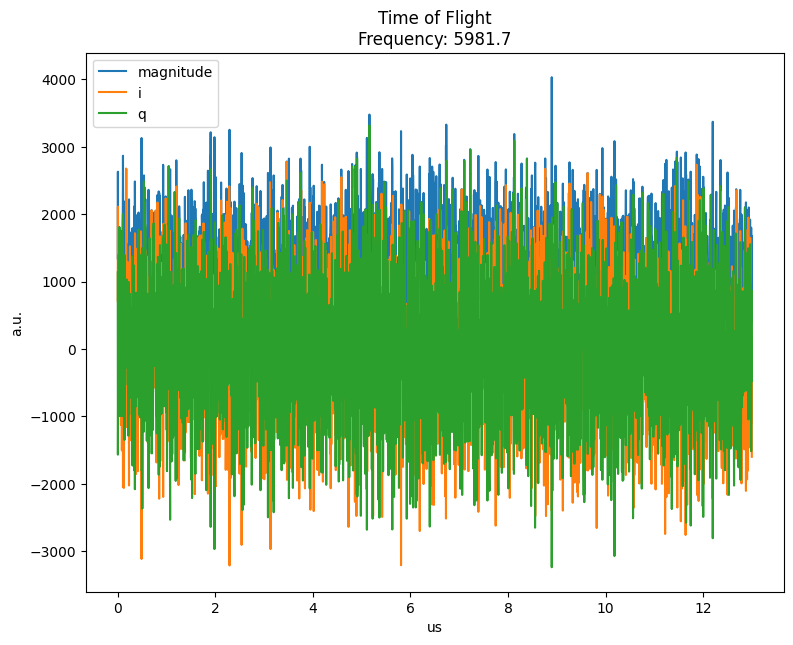

Creating directory G:\My Drive\chatot\data\time_of_flight\2024_11_20\15_57_29\


In [17]:
meas.display() # purposefully saving a plot to ensure the directory is created, as is done in my actual code

In [18]:
print(os.path.isdir(datapath))
print(os.path.exists(datapath))
meas.save_data()

True
True
